# Build barcode variant table
This Python Jupyter notebook builds consensus sequences for barcoded variants from the mutations called in the processed PacBio CCSs.
It then uses these consensus sequences to build a codon variant table.

## Set up analysis
### Import Python modules.
Use [plotnine](https://github.com/has2k1/plotnine) for ggplot2-like plotting.

The analysis uses the Bloom lab's [alignparse](https://jbloomlab.github.io/alignparse) and [dms_variants](https://jbloomlab.github.io/dms_variants) packages:

In [88]:
import os
import re
import warnings

import alignparse
import alignparse.consensus
import alignparse.targets

import dms_variants
import dms_variants.codonvarianttable
from dms_variants.constants import CBPALETTE
import dms_variants.plotnine_themes

from IPython.display import display, HTML

import numpy

import pandas as pd

from plotnine import *

import yaml

Set [plotnine](https://github.com/has2k1/plotnine) theme to the gray grid one defined in [dms_variants](https://jbloomlab.github.io/dms_variants):

In [89]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key software:

In [90]:
print(f"Using alignparse version {alignparse.__version__}")
print(f"Using dms_variants version {dms_variants.__version__}")

Using alignparse version 0.2.4
Using dms_variants version 0.8.9


Ignore warnings that clutter output:

In [91]:
warnings.simplefilter('ignore')

### Parameters for notebook
Read the configuration file:

In [92]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directories if needed:

In [93]:
os.makedirs(config['variants_dir'], exist_ok=True)
os.makedirs(config['figs_dir'], exist_ok=True)

## Build variant consensus sequences
We now use the processed CCSs to build a consensus sequence (really, list of mutations) for each barcoded variant in each library.

### Get processed CCSs
Read the CSV file with the processed CCSs into a data frame:

In [94]:
processed_ccs = pd.read_csv(config['processed_ccs_file_Wuhan_Hu_1'], na_filter=None)
processed_ccs = processed_ccs.append(pd.read_csv(config['processed_ccs_file_E484K'], na_filter=None))
processed_ccs = processed_ccs.append(pd.read_csv(config['processed_ccs_file_N501Y'], na_filter=None))
processed_ccs = processed_ccs.append(pd.read_csv(config['processed_ccs_file_B1351'], na_filter=None))

nlibs = processed_ccs['library'].nunique()  # number of unique libraries

ntargets = processed_ccs['target'].nunique()  # number of unique targets

print(f"Read {len(processed_ccs)} CCSs from {nlibs} libraries and {ntargets} targets.")

Read 1561447 CCSs from 2 libraries and 4 targets.


Here are the first few lines:

In [95]:
display(HTML(processed_ccs.head().to_html(index=False)))

library,query_name,gene_mutations,gene_accuracy,barcode,barcode_accuracy,target
pool1,m64076_210624_232647/23/ccs,G460A,1.000000,GGAAGCAGCATTATTA,1.0,Wuhan_Hu_1
pool1,m64076_210624_232647/50/ccs,A238G T239A C240A,0.999968,GTAAAGACCACACATA,1.0,Wuhan_Hu_1
pool1,m64076_210624_232647/228/ccs,C134G C135G,1.000000,TACATAAGGACTTGAA,1.0,Wuhan_Hu_1
pool1,m64076_210624_232647/341/ccs,A214T T215G T216G A358T A359C,1.000000,TCAGTACTTCAGGACG,1.0,Wuhan_Hu_1
pool1,m64076_210624_232647/405/ccs,C502A A503G A504G,1.000000,GGATCCCCTTAGTTGT,1.0,Wuhan_Hu_1


Overall statistics on number of total CCSs and number of unique barcodes:

In [96]:
display(HTML(
    processed_ccs
    .groupby(['target', 'library'])
    .aggregate(total_CCSs=('barcode', 'size'),
               unique_barcodes=('barcode', 'nunique'))
    .assign(avg_CCSs_per_barcode=lambda x: x['total_CCSs'] / x['unique_barcodes'])
    .round(2)
    .to_html()
    ))

### Filter processed CCSs
We have the PacBio `ccs` program's estimated "accuracy" for both the barcode and the gene sequence for each processed CCS.
We will filter the CCSs to only keep ones of sufficiently high accuracy.

First, we want to plot the accuracies.
It is actually visually easier to look at the error rate, which is one minus the accuracy.
Because we want to plot on a log scale (which can't show error rates of zero), we define a *error_rate_floor*, and set all error rates less than this to that value:

In [97]:
error_rate_floor = 1e-7  # error rates < this set to this
if error_rate_floor >= config['max_error_rate']:
    raise ValueError('error_rate_floor must be < max_error_rate')

processed_ccs = (
    processed_ccs
    .assign(barcode_error=lambda x: numpy.clip(1 - x['barcode_accuracy'],
                                               error_rate_floor, None),
            gene_error=lambda x: numpy.clip(1 - x['gene_accuracy'],
                                            error_rate_floor, None)
            )
    )

Now plot the error rates, drawing a dashed vertical line at the threshold separating the CCSs we retain for consensus building versus those that we discard:

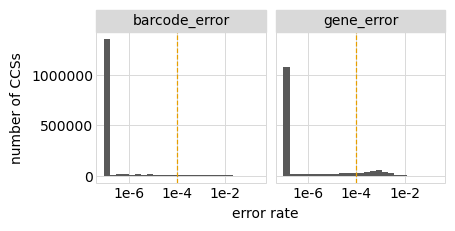

In [98]:
_ = (
 ggplot(processed_ccs
        .melt(value_vars=['barcode_error', 'gene_error'],
              var_name='feature_type', value_name='error rate'),
        aes('error rate')) +
 geom_histogram(bins=25) +
 geom_vline(xintercept=config['max_error_rate'],
            linetype='dashed',
            color=CBPALETTE[1]) +
 facet_wrap('~ feature_type') +
 theme(figure_size=(4.5, 2)) +
 ylab('number of CCSs') +
 scale_x_log10()
 ).draw()

Flag the CCSs to retain, and indicate how many we are retaining and purging due to the accuracy filter:

In [99]:
processed_ccs = (
    processed_ccs
    .assign(retained=lambda x: ((x['gene_error'] < config['max_error_rate']) &
                                (x['barcode_error'] < config['max_error_rate'])))
    )

Here are number of retained CCSs:

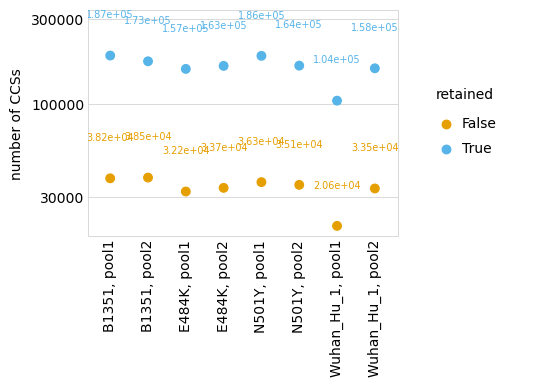

In [100]:
_ = (
 ggplot(processed_ccs.assign(xlabel=lambda x: x['target'] + ', ' + x['library'])
                     .groupby(['xlabel', 'retained'])
                     .size()
                     .rename('count')
                     .reset_index(),
        aes('xlabel', 'count', color='retained', label='count')) +
 geom_point(size=3) +
 geom_text(va='bottom', size=7, ha='center',format_string='{:.3g}', nudge_y=0.2) +
 theme(figure_size=(0.5 * nlibs * ntargets, 3),
       panel_grid_major_x=element_blank(),
       axis_text_x=element_text(angle=90),
       ) +
 scale_y_log10(name='number of CCSs') +
 xlab('') +
 scale_color_manual(values=CBPALETTE[1:])
 ).draw()

### Sequences per barcode
How many times is each barcode sequenced?
This is useful to know for thinking about building the barcode consensus.

First, plot the distribution of the number of times each **barcode** is observed among the retained CCSs:

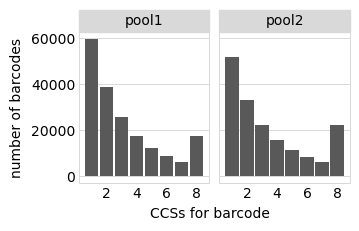

In [101]:
max_count = 8 # in plot, group all barcodes with >= this many counts

p = (
 ggplot(
    processed_ccs
     .query('retained')
     .groupby(['library', 'barcode'])
     .size()
     .rename('nseqs')
     .reset_index()
     .assign(nseqs=lambda x: numpy.clip(x['nseqs'], None, max_count)),
    aes('nseqs')) +
 geom_bar() +
 facet_wrap('~ library', nrow=1) +
 theme(figure_size=(1.75 * nlibs, 2),
       panel_grid_major_x=element_blank(),
       ) +
 ylab('number of barcodes') +
 xlab('CCSs for barcode')
 )

_ = p.draw()

Now we plot the distribution of the number of **sequences** with barcodes that are observed a given number of time (again among retained CCSs).
This plot differs from the one above because if a barcode is observed multiple times it is given one count in the barcode-count plot above (which tallies barcodes) but multiple counts in the sequence-count plot below:

In [102]:
# _ = (
#  ggplot(
#     processed_ccs
#      .query('retained')
#      .assign(barcode_counts=1)
#      .assign(barcode_counts=lambda x: numpy.clip(
#         x.groupby(['library', 'barcode']).transform('count'), None, max_count)),
#     aes('barcode_counts')) +
#  geom_bar() +
#  facet_wrap('~ library', nrow=1) +
#  theme(figure_size=(1.75 * nlibs, 2),
#        panel_grid_major_x=element_blank(),) +
#  ylab('number of CCSs') +
#  xlab('CCSs per barcode')
#  ).draw()

### Empirical accuracy of CCSs
We want to directly estimate the accuracy of the gene-barcode link rather than relying on the PacBio `ccs` accuracy, which doesn't include inaccuracies due to things like strand exchange or the same barcode on different sequences.

One way to do this is to examine instances when we have multiple sequences for the same barcode. 
We can calculate the empirical accuracy of the sequences by looking at all instances of multiple sequences of the same barcode and determining how often they are identical.
This calculation is performed by `alignparse.consensus.empirical_accuracy` using the equations described in the docs for that function.

We will do this four for sets of sequences:

 1. All of the CCSs retained above.
 2. CCSs retained by applying a PacBio `ccs` accuracy filter 10-fold more stringent than the one above.
    The rationale is that if this improves the concordance (real accuracy) of the CCSs substantially then maybe we should make the accuracy filter more stringent.
 3. Like (1) but excluding all CCSs with indels.
    the rationale is that we only really care about substitutions, and will exclude sequences with indels anyway.
 4. Like (2) but excluding all CCSs with indels.
 
First, we annotate the sequences with the number of indels and whether they have an indel to enable categorization into the aforementioned sets:

In [103]:
processed_ccs.head()

,library,query_name,gene_mutations,gene_accuracy,barcode,barcode_accuracy,target,barcode_error,gene_error,retained
0,pool1,m64076_210624_232647/23/ccs,G460A,1.000000,GGAAGCAGCATTATTA,1.0,Wuhan_Hu_1,1.000000e-07,1.000000e-07,True
1,pool1,m64076_210624_232647/50/ccs,A238G T239A C240A,0.999968,GTAAAGACCACACATA,1.0,Wuhan_Hu_1,1.000000e-07,3.211507e-05,True
2,pool1,m64076_210624_232647/228/ccs,C134G C135G,1.000000,TACATAAGGACTTGAA,1.0,Wuhan_Hu_1,1.000000e-07,1.000000e-07,True
3,pool1,m64076_210624_232647/341/ccs,A214T T215G T216G A358T A359C,1.000000,TCAGTACTTCAGGACG,1.0,Wuhan_Hu_1,1.000000e-07,1.000000e-07,True
4,pool1,m64076_210624_232647/405/ccs,C502A A503G A504G,1.000000,GGATCCCCTTAGTTGT,1.0,Wuhan_Hu_1,1.000000e-07,1.000000e-07,True


In [104]:
len(processed_ccs)

1561447

In [105]:
processed_ccs = alignparse.consensus.add_mut_info_cols(processed_ccs,
                                                       mutation_col='gene_mutations',
                                                       n_indel_col='n_indels')

processed_ccs = processed_ccs.assign(has_indel=lambda x: x['n_indels'] > 0)
len(processed_ccs)

5850189

In [106]:
processed_ccs.head()

,library,query_name,gene_mutations,gene_accuracy,barcode,barcode_accuracy,target,barcode_error,gene_error,retained,n_indels,has_indel
0,pool1,m64076_210624_232647/23/ccs,G460A,1.0,GGAAGCAGCATTATTA,1.0,Wuhan_Hu_1,1.000000e-07,1.000000e-07,True,0,False
0,pool1,m64076_210624_232647/23/ccs,G460A,1.0,GGAAGCAGCATTATTA,1.0,Wuhan_Hu_1,1.000000e-07,1.000000e-07,True,0,False
0,pool1,m64076_210624_232647/23/ccs,G460A,1.0,GGAAGCAGCATTATTA,1.0,Wuhan_Hu_1,1.000000e-07,1.000000e-07,True,0,False
0,pool1,m64076_210624_232647/23/ccs,G460A,1.0,GGAAGCAGCATTATTA,1.0,Wuhan_Hu_1,1.000000e-07,1.000000e-07,True,0,False
0,pool1,m64076_210624_232647/32/ccs,,1.0,CGACAAGACAAGGAAA,1.0,E484K,1.000000e-07,1.000000e-07,True,0,False


Plot how many sequences have indels:

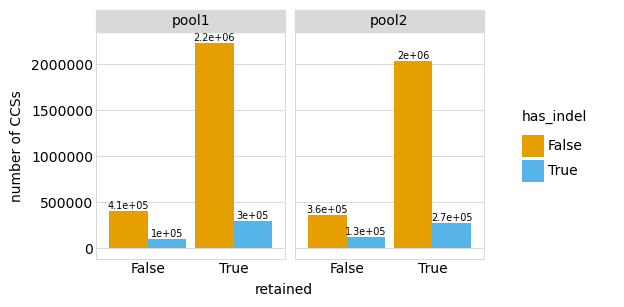

In [17]:
_ = (
 ggplot(processed_ccs,
        aes('retained', fill='has_indel')) +
 geom_bar(position='dodge') +
 geom_text(aes(label='..count..'), stat='count', va='bottom', size=7,
           position=position_dodge(width=0.9), format_string='{:.2g}') +
 theme(figure_size=(2.5 * nlibs, 3),
       panel_grid_major_x=element_blank(),
       ) +
 ylab('number of CCSs') +
 scale_fill_manual(values=CBPALETTE[1:]) +
 facet_wrap('~ library', nrow=1)
 ).draw()

Now get the empirical accuracy for each of the CCS groups mentioned above:

In [18]:
high_acc = config['max_error_rate'] / 10
empirical_acc = []

for desc, query_str in [
        ('retained', 'retained'),
        ('retained, no indel', 'retained and not has_indel'),
        ('10X accuracy',
         f"(gene_error < {high_acc}) and (barcode_error < {high_acc})"),
        ('10X accuracy, no indel',
         f"(gene_error < {high_acc}) and (barcode_error < {high_acc}) and not has_indel")
        ]:
    # get just CCSs in that category
    df = processed_ccs.query(query_str)
    
    # compute empirical accuracy
    empirical_acc.append(
        alignparse.consensus.empirical_accuracy(df,
                                                mutation_col='gene_mutations')
        .assign(description=desc)
        .merge(df
               .groupby('library')
               .size()
               .rename('number_CCSs')
               .reset_index()
               )
        )

# make description categorical to preserve order, and annotate as "actual"
# the category ("retained, no indel") that we will use for building variants.
empirical_acc = (
    pd.concat(empirical_acc, ignore_index=True, sort=False)
    .assign(description=lambda x: pd.Categorical(x['description'],
                                                 x['description'].unique(),
                                                 ordered=True),
            actual=lambda x: numpy.where(x['description'] == 'retained, no indel',
                                         True, False),
            )
    )

Display table of the empirical accuracies:

In [19]:
display(HTML(empirical_acc.to_html(index=False)))

library,accuracy,description,number_CCSs,actual
pool1,0.989263,retained,2536864,False
pool2,0.984908,retained,2311629,False
pool1,0.990028,"retained, no indel",2237796,True
pool2,0.987897,"retained, no indel",2037244,True
pool1,0.991839,10X accuracy,2356848,False
pool2,0.988597,10X accuracy,2137175,False
pool1,0.992298,"10X accuracy, no indel",2082552,False
pool2,0.990683,"10X accuracy, no indel",1891211,False


Plot the empirical accuracies, using a different color to show the category that we will actually use:

Saving plot to results/figures/empirical_CCS_accuracy.pdf


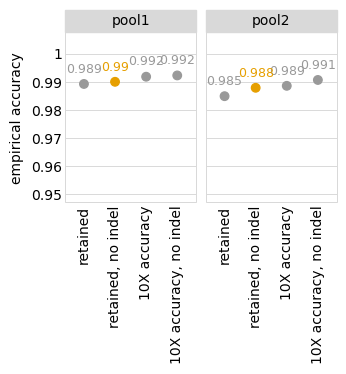

In [20]:
p = (
    ggplot(empirical_acc,
           aes('description', 'accuracy', color='actual', label='accuracy')
           ) +
    geom_point(size=3) +
    geom_text(va='bottom', size=9, format_string='{:.3g}', nudge_y=0.003) +
    facet_wrap('~ library', ncol=8) +
    theme(figure_size=(1.75 * nlibs, 2.25),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),
          ) +
    xlab('') +
    scale_y_continuous(name='empirical accuracy', limits=(0.95, 1.005)) +
    scale_color_manual(values=CBPALETTE, guide=False)
    )

plotfile = os.path.join(config['figs_dir'], 'empirical_CCS_accuracy.pdf')
print(f"Saving plot to {plotfile}")
_ = p.draw()

The above analysis shows that if we exclude sequences with indels (which we plan to do among our consensus sequences), then the accuracy of each CCS is around 99%. 
We do **not** get notably higher empirical accuracy by imposing a more stringent filter from the PacBio `ccs` program, indicating that the major sources of error are due to processes that are not modeled in this program's accuracy filter (perhaps strand exchange or barcode sharing).

Note that this empirical accuracy is for a **single** CCS.
When we build the consensus sequences for each barcode below, we will take the consensus of CCSs within a barcode.
So for barcodes with multiple CCSs, the actual accuracy of the consensus sequences will be higher than the empirical accuracy above due to capturing information from multiple CCSs.

### Consensus sequences for barcodes
We call the consensus sequence for each barcode using the simple method implemented in [alignparse.consensus.simple_mutconsensus](https://jbloomlab.github.io/alignparse/alignparse.consensus.html?highlight=simple_mutconsensus#alignparse.consensus.simple_mutconsensus).
The documentation for that function explains the method in detail, but basically it works like this:
 1. When there is just one CCS per barcode, the consensus is just that sequence.
 2. When there are multiple CCSs per barcode, they are used to build a consensus--however, the entire barcode is discarded if there are many differences between CCSs with the barcode, or high-frequency non-consensus mutations. The reason that barcodes are discarded in such cases as many differences between CCSs or high-frequency non-consensus mutations suggest errors such as barcode collisions or strand exchange.
 
First, call the consensus for each barcode including **all** retained sequences, even those with indels:

In [62]:
len(processed_ccs)

5850189

In [21]:
consensus, dropped = alignparse.consensus.simple_mutconsensus(
                        processed_ccs.query('retained'),
                        group_cols=('library', 'barcode', 'target'),
                        mutation_col='gene_mutations',
                        )

Here are the first few lines of the data frame of consensus sequences for each barcode.
In addition to giving the library, barcode, target, and mutations, it also has a column indicating how many CCSs support the variant call:

In [22]:
display(HTML(consensus.head().to_html(index=False)))

library,barcode,target,gene_mutations,variant_call_support
pool1,AAAAAAAAAAAAAGAA,N501Y,A136C C137A,4
pool1,AAAAAAAAAAATTTAA,Wuhan_Hu_1,,16
pool1,AAAAAAAAAACACATT,B1351,,32
pool1,AAAAAAAAAACGCGTA,Wuhan_Hu_1,G460A A461C A462T,12
pool1,AAAAAAAAAACTCCAA,Wuhan_Hu_1,T466A T468G,8


Since we retain variants with substitutions but ignore those with indels, add information about substitution mutations and number of indels:

In [23]:
consensus = alignparse.consensus.add_mut_info_cols(
                    consensus,
                    mutation_col='gene_mutations',
                    sub_str_col='substitutions',
                    n_indel_col='number_of_indels',
                    overwrite_cols=True)

display(HTML(consensus.head().to_html(index=False)))

library,barcode,target,gene_mutations,variant_call_support,substitutions,number_of_indels
pool1,AAAAAAAAAAAAAGAA,N501Y,A136C C137A,4,A136C C137A,0
pool1,AAAAAAAAAAATTTAA,Wuhan_Hu_1,,16,,0
pool1,AAAAAAAAAACACATT,B1351,,32,,0
pool1,AAAAAAAAAACGCGTA,Wuhan_Hu_1,G460A A461C A462T,12,G460A A461C A462T,0
pool1,AAAAAAAAAACTCCAA,Wuhan_Hu_1,T466A T468G,8,T466A T468G,0


Plot distribution of number of CCSs supporting each variant call (consensus), indicating whether or not there is an indel:

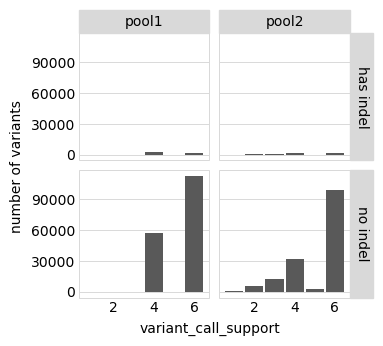

In [24]:
max_variant_call_support = 6  # group variants with >= this much support

_ = (
 ggplot(consensus
        .assign(variant_call_support=lambda x: numpy.clip(x['variant_call_support'],
                                                          None,
                                                          max_variant_call_support),
                indel_state=lambda x: numpy.where(x['number_of_indels'] > 0,
                                                  'has indel', 'no indel')
                ),
        aes('variant_call_support')) +
 geom_bar() +
 ylab('number of variants') +
 facet_grid('indel_state ~ library') +
 theme(figure_size=(1.75 * nlibs, 3.5),
       panel_grid_major_x=element_blank(),
       ) 
 ).draw()

We see that most variant consensus sequences do **not** have indels, especially if we limit to the more "accurate" ones that have multiple CCSs supporting them.

We will ignore all consensus sequences with indels in the variant-barcode lookup table. 
We do this for two reasons:
 1. When there is just one CCS supporting a consensus, it is less likely to be accurate as indels are the main mode of PacBio error.
 2. For the purposes of our studies, we are interested in point mutations rather than indels anyway.
 
Here are number of valid consensus sequence (no indels) for each library and target:

library,target,consensus sequences
pool1,B1351,43005
pool1,E484K,42357
pool1,N501Y,45271
pool1,Wuhan_Hu_1,39400
pool2,B1351,38457
pool2,E484K,23770
pool2,N501Y,49600
pool2,Wuhan_Hu_1,40773


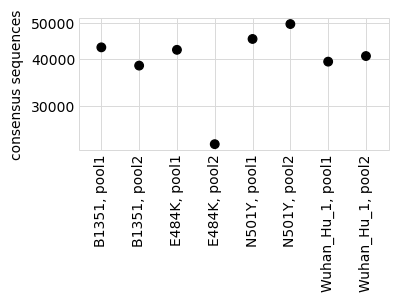

In [25]:
consensus = consensus.query('number_of_indels == 0')

lib_target_counts = (
    consensus
    .groupby(['library', 'target'])
    .size()
    .rename('consensus sequences')
    .reset_index()
    )

display(HTML(lib_target_counts.to_html(index=False)))

p = (ggplot(lib_target_counts.assign(xlabel=lambda x: x['target'] + ', ' + x['library']),
            aes('xlabel', 'consensus sequences')) +
     geom_point(size=3) +
     theme(figure_size=(0.5 * nlibs * ntargets, 1.75),
           axis_text_x=element_text(angle=90)) +
     xlab('') +
     scale_y_log10()
     )

_ = p.draw()

Are there any barcodes in the same library that are shared across targets?
If so, we need to get rid of those as they will be confounded in barcode parsing:

In [26]:
dup_barcodes = (
    consensus
    .groupby(['library', 'barcode'])
    .size()
    .rename('duplicate_count')
    .reset_index()
    .query('duplicate_count > 1')
    )

print('Here are duplicated barcodes:')
display(HTML(dup_barcodes.head().to_html(index=False)))

print(f"\nRemoving the {len(dup_barcodes)} duplicated barcodes."
      f"Started with {len(consensus)} barcodes:")
consensus = (
    consensus
    .merge(dup_barcodes, on=['library', 'barcode'], how='outer')
    .query('duplicate_count.isnull()', engine='python')
    )
print(f"After removing duplicates, there are {len(consensus)} barcodes.")

Here are duplicated barcodes:


library,barcode,duplicate_count
pool1,AAAGAGACAATTCGTT,2
pool1,AAAGCCGGATTCGTAC,2
pool1,AAATATGAAAGATACA,2
pool1,AACAGCCGATTTACAA,2
pool1,AAGAGCATAAGCCCCA,2



Removing the 347 duplicated barcodes.Started with 322633 barcodes:
After removing duplicates, there are 321939 barcodes.


Below we write the retained consensus sequences to a CSV file that links the nucleotide mutations to the barcodes.
(The next section analyzes this variant table in detail, and provides have more precise information on the number of variants and relevant statistics):

In [27]:
print(f"Writing nucleotide variants to {config['nt_variant_table_file']}")
      
(consensus
 [['target', 'library', 'barcode', 'substitutions', 'variant_call_support']]
 .to_csv(config['nt_variant_table_file'], index=False)
 )
      
print('Here are the first few lines of this file:')
display(HTML(
    pd.read_csv(config['nt_variant_table_file'], na_filter=None)
    .head()
    .to_html(index=False)
    ))

Writing nucleotide variants to results/variants/nucleotide_variant_table.csv
Here are the first few lines of this file:


target,library,barcode,substitutions,variant_call_support
N501Y,pool1,AAAAAAAAAAAAAGAA,A136C C137A,4
Wuhan_Hu_1,pool1,AAAAAAAAAAATTTAA,,16
B1351,pool1,AAAAAAAAAACACATT,,32
Wuhan_Hu_1,pool1,AAAAAAAAAACGCGTA,G460A A461C A462T,12
Wuhan_Hu_1,pool1,AAAAAAAAAACTCCAA,T466A T468G,8


What happened to the barcodes that we "dropped" because we could not construct a reliable consensus?
The `dropped` data frame from [alignparse.consensus.simple_mutconsensus](https://jbloomlab.github.io/alignparse/alignparse.consensus.html?highlight=simple_mutconsensus#alignparse.consensus.simple_mutconsensus) has this information:

In [28]:
display(HTML(dropped.head().to_html(index=False)))

library,barcode,target,drop_reason,nseqs
pool1,AAAAAAAAACCAGAGG,E484K,minor subs too frequent,56
pool1,AAAAAAAAACTTAACA,E484K,minor subs too frequent,16
pool1,AAAAAAAACAACACAA,N501Y,minor subs too frequent,8
pool1,AAAAAAAAGGGTATTA,E484K,minor indels too frequent,12
pool1,AAAAAAACACTCGTCT,N501Y,minor subs too frequent,16


Summarize the information in this data frame on dropped barcodes with the plot below.
This plot shows several things.
First, we see that the total number of barcodes dropped is modest (just a few thousand per library) relative to the total number of barcodes per library (seen above to be on the order of hundreds of thousands).
Second, the main reason that barcodes are dropped is that there are CCSs within the same barcode with suspiciously large numbers of mutations relative to the consensus---which we use as a filter to discard the entire barcode as it could indicate strand exchange or some other issue.
In any case, the modest number of dropped barcodes indicates that there probably isn't much of a need to worry: 

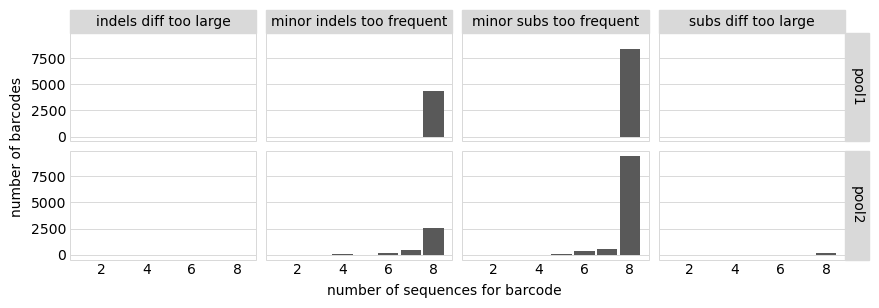

In [29]:
max_nseqs = 8  # plot together all barcodes with >= this many sequences

_ = (
 ggplot(
    dropped.assign(nseqs=lambda x: numpy.clip(x['nseqs'], None, max_nseqs)),
    aes('nseqs')) + 
 geom_bar() + 
 scale_x_continuous(limits=(1, None)) +
 xlab('number of sequences for barcode') +
 ylab('number of barcodes') +
 facet_grid('library ~ drop_reason') +
 theme(figure_size=(10, 1.5 * nlibs),
       panel_grid_major_x=element_blank(),
       )
 ).draw()

## Create barcode-variant table
We now create a [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) that stores and processes all the information about the variant consensus sequences.
Below we initialize such a table, and then analyze information about its composition.

### Initialize codon variant table
In order to initialize the codon variant table, we need two pieces of information:
  1. The wildtype gene sequence.
  2. The list of nucleotide mutations for each variant as determined in the consensus calling above.

Read "wildtype" gene sequence to which we made the alignments (in order to do this, initialize an `alignparse.Targets` and get the gene sequence from it):

In [34]:
targets = alignparse.targets.Targets(seqsfile=config['amplicons_all'],
                                     feature_parse_specs=config['feature_parse_specs'])
geneseq = targets.get_target(config['primary_target']).get_feature('gene').seq

print(f"Read gene of {len(geneseq)} nts for {config['primary_target']} from {config['amplicons']}")

Read gene of 603 nts for SARS-CoV-2 from data/PacBio_amplicons.gb


Now initialize the codon variant table using this wildtype sequence and our list of nucleotide mutations for each variant:

In [35]:
variants = dms_variants.codonvarianttable.CodonVariantTable(
                barcode_variant_file=config['nt_variant_table_file'],
                geneseq=geneseq,
                primary_target=config['primary_target'],
                )

### Basic stats on variants
We now will analyze the variants.
In this call and in the plots below, we set `samples=None` as we aren't looking at variant counts in specific samples, but are simply looking at properties of the variants in the table.

Here are the number of variants for each target:

In [36]:
display(HTML(
    variants
    .n_variants_df(samples=None)
    .pivot_table(index=['target'],
                 columns='library',
                 values='count')
    .to_html()
    ))

library,bg2-2,bg4-1,bg4-2,bg1-2,bg2-1,bg3-2,bg1-1,bg3-1,all libraries
target,,,,,,,,,
B_1_351,2.0,11292.0,10003.0,NaN,NaN,NaN,NaN,NaN,21297.0
E484K,6665.0,NaN,1.0,3.0,11808.0,6.0,NaN,NaN,18483.0
N501Y,66.0,1.0,3.0,7.0,NaN,12957.0,10.0,11931.0,24975.0
SARS-CoV-2,172.0,4.0,NaN,42093.0,204.0,360.0,40305.0,318.0,83456.0


Plot the number of variants supported by each number of CCSs:

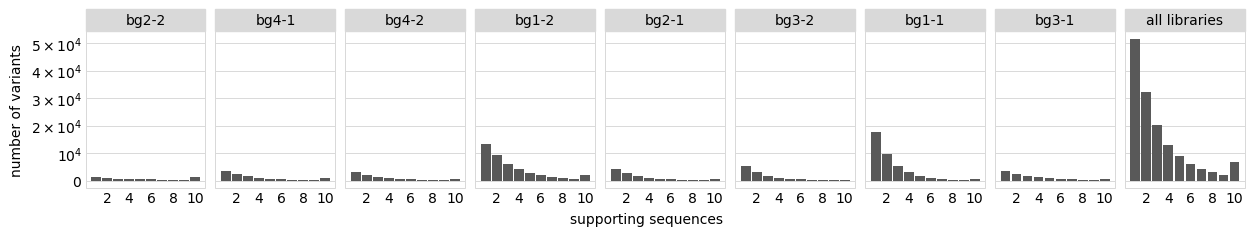

In [37]:
max_support = 10  # group variants with >= this much support

p = variants.plotVariantSupportHistogram(max_support=max_support,
                                         widthscale=1.1,
                                         heightscale=0.9)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

### Mutations per variant
Plot the number of barcoded variants with each number of amino-acid and codon mutations.
This is for the primary target only, and doesn't include the spiked-in secondary targets:

Saving plot to results/figures/n_aa_muts_per_variant.pdf
Saving plot to results/figures/n_codon_muts_per_variant.pdf


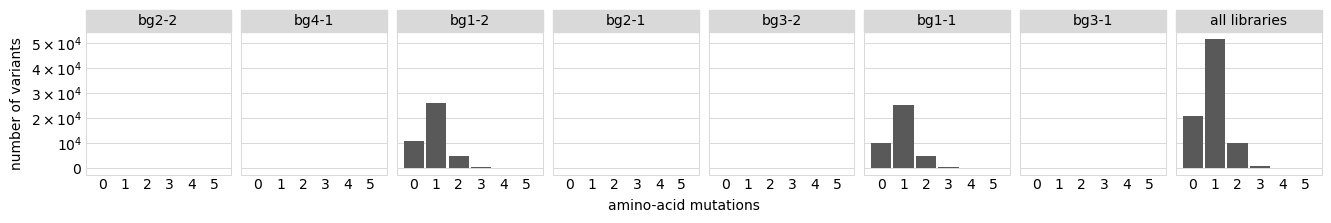

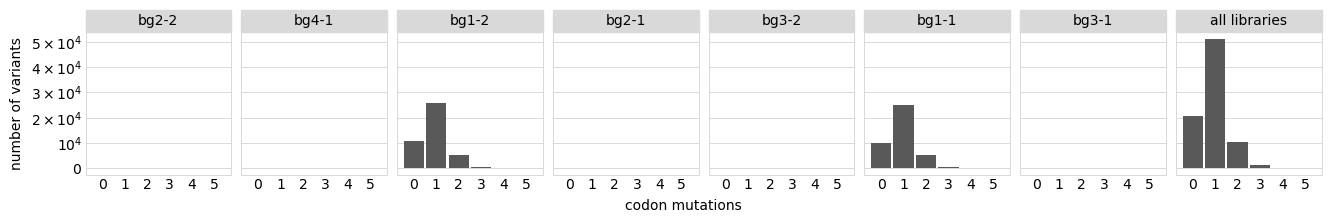

In [38]:
max_muts = 7  # group all variants with >= this many mutations

for mut_type in ['aa', 'codon']:
    p = variants.plotNumMutsHistogram(mut_type, samples=None, max_muts=max_muts,
                                      widthscale=1.1,
                                      heightscale=0.9)
    p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    _ = p.draw()
    plotfile = os.path.join(config['figs_dir'], f"n_{mut_type}_muts_per_variant.pdf")
    print(f"Saving plot to {plotfile}")
    p.save(plotfile)

Plot the frequencies of different codon mutation types among **all** variants (any number of mutations), again only for primary target:

Saving plot to results/figures/avg_muts_per_variant.pdf


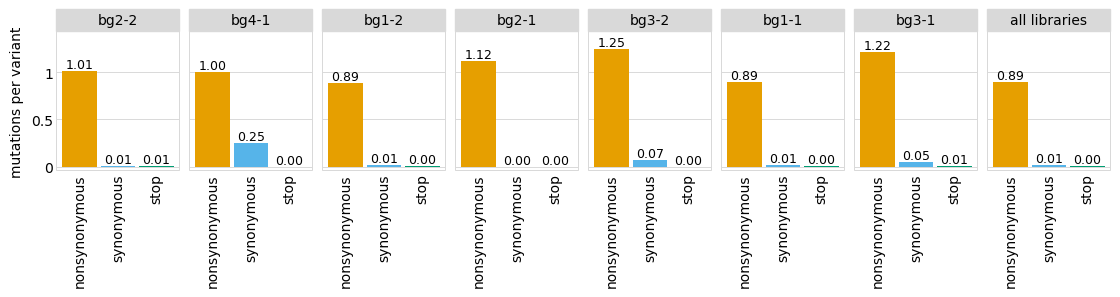

In [39]:
p = variants.plotNumCodonMutsByType(variant_type='all', samples=None,
                                    ylabel='mutations per variant',
                                    heightscale=0.8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()
plotfile = os.path.join(config['figs_dir'], f"avg_muts_per_variant.pdf")
print(f"Saving plot to {plotfile}")
p.save(plotfile)

Variants supported by multiple PacBio CCSs should have fewer spurious mutations since sequencing errors are very unlikely to occur on two CCSs.
Below we plot the number of codon mutations per variant among variants with at least two CCSs supporting their call.
The difference in mutation rates here and in the plot above (that does not apply the `min_support=2` filter) gives some estimate of the frequency of mutations in our variants our spurious.
In fact, we see the numbers are very similar, indicating that few of the mutations are spurious:

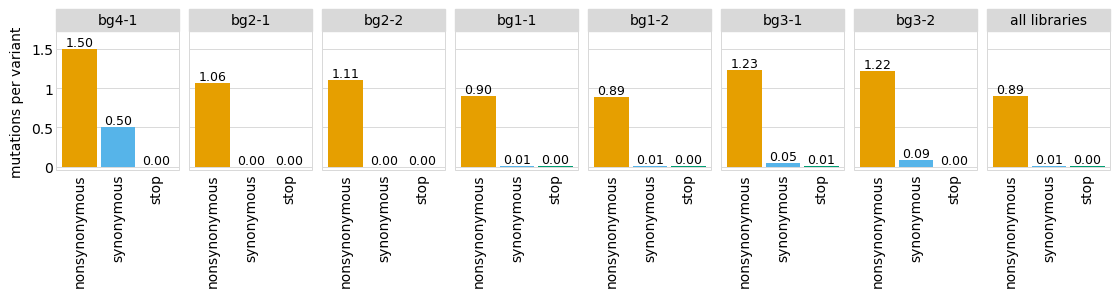

In [40]:
p = variants.plotNumCodonMutsByType(variant_type='all', samples=None,
                                    ylabel='mutations per variant', 
                                    min_support=2, heightscale=0.8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

### Completeness of mutation sampling
We examine how completely amino-acid mutations are sampled by the variants for the primary target, looking at single-mutant variants only and all variants.
The plot below shows that virtually every mutation is found in a variant in each library, even if we just look among the single mutants.
Things look especially good if we aggregate across libraries:

Saving plot to results/figures/variant_cumul_all_mut_coverage.pdf
Saving plot to results/figures/variant_cumul_single_mut_coverage.pdf


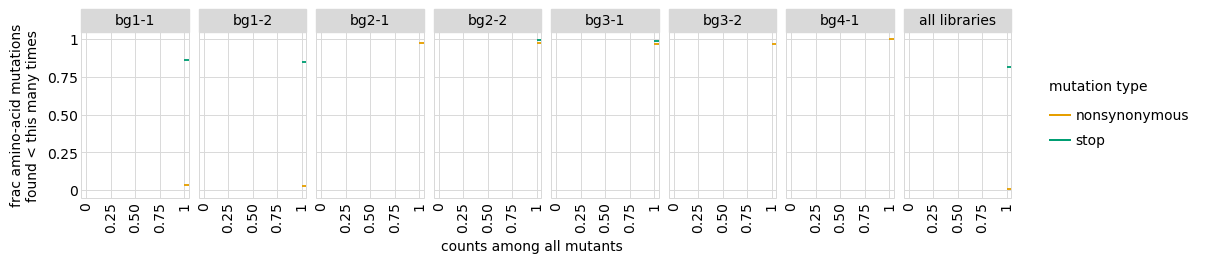

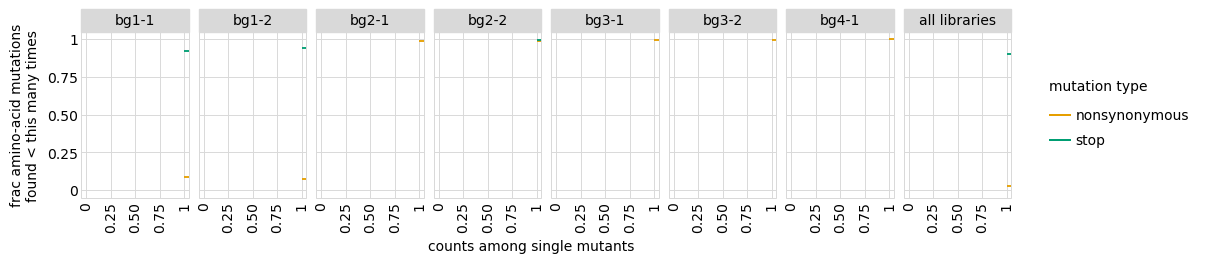

In [41]:
for variant_type in ['all', 'single']:
    p = variants.plotCumulMutCoverage(variant_type, mut_type='aa', samples=None)
    _ = p.draw()
    plotfile = os.path.join(config['figs_dir'],
                            f"variant_cumul_{variant_type}_mut_coverage.pdf")
    print(f"Saving plot to {plotfile}")
    p.save(plotfile)

To get more quantitative information like that plotted above, we determine how many mutations are found 0, 1, or >1 times both among single and all mutants for the primary target:

In [42]:
count_dfs = []
for variant_type in ['all', 'single']:
    i_counts = (variants.mutCounts(variant_type, mut_type='aa', samples=None)
                .assign(variant_type=variant_type)
                )
    count_dfs += [i_counts.assign(include_stops=True),
                  i_counts
                  .query('not mutation.str.contains("\*")', engine='python')
                  .assign(include_stops=False)
                  ]
    
display(HTML(
    pd.concat(count_dfs)
    .assign(count=lambda x: (numpy.clip(x['count'], None, 2)
                             .map({0: '0', 1: '1', 2:'>1'}))
            )
    .groupby(['variant_type', 'include_stops', 'library', 'count'])
    .aggregate(number_of_mutations=pd.NamedAgg(column='mutation', aggfunc='count'))
    .to_html()
    ))

### Mutation frequencies along gene
We plot the frequencies of mutations along the gene among the variants for the primary target.
Ideally, this would be uniform.
We make the plot for both all variants and single-mutant / wildtype variants:

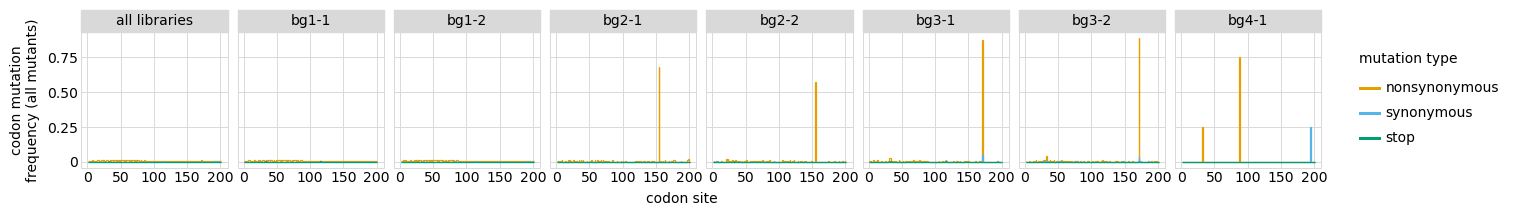

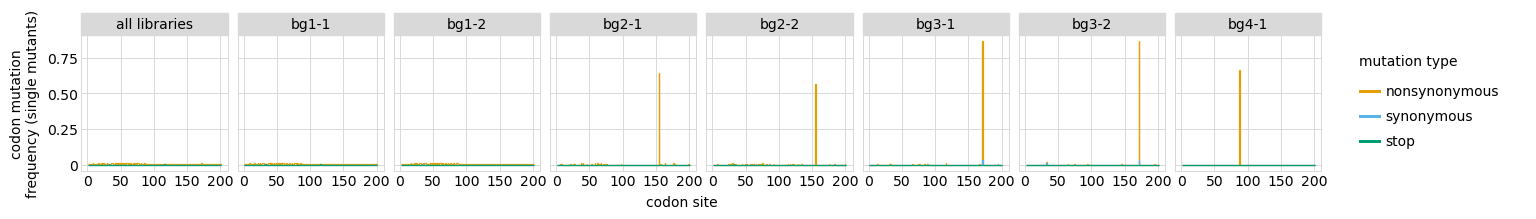

In [43]:
for variant_type in ['all', 'single']:
    p = variants.plotMutFreqs(variant_type, mut_type='codon', samples=None)
    p.draw()

We can also use heat maps to examine the extent to which specific amino-acid or codon mutations are over-represented.
These heat maps are large, so we make them just for all variants and the merge of all libraries:

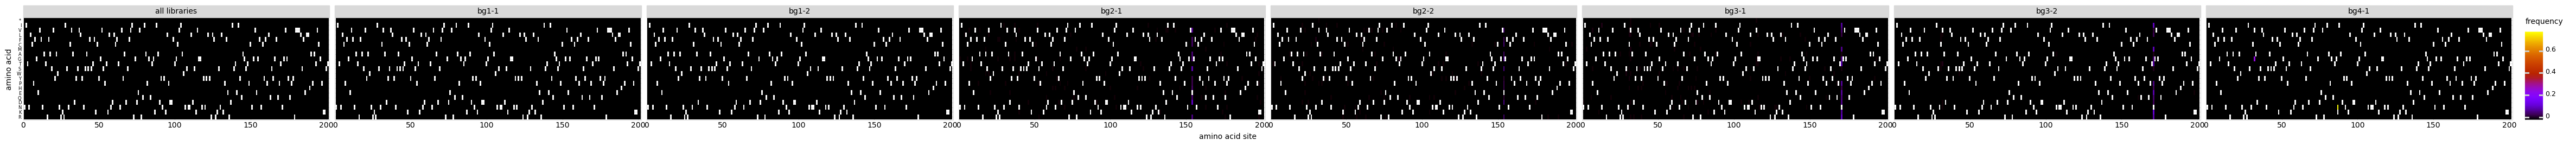

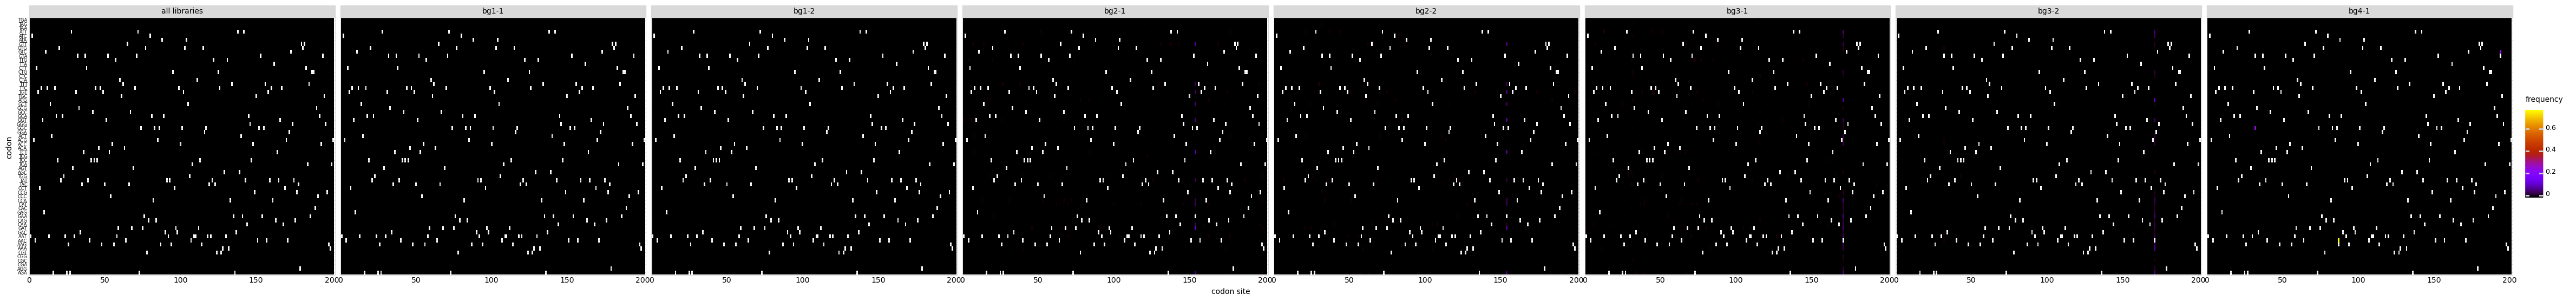

In [44]:
for mut_type in ['aa', 'codon']:
    p = variants.plotMutHeatmap('all', mut_type, samples=None, #libraries='all_only',
                                widthscale=2)
    p.draw()

### Write codon-variant table
We write the codon variant table to a CSV file.
This table looks like this:

In [45]:
display(HTML(
    variants.barcode_variant_df
    .head()
    .to_html(index=False)
    ))

target,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
B_1_351,bg2-2,GAACAGCGAATGACAT,1,B_1_351,B_1_351,0,0
B_1_351,bg2-2,GAATTGTCTGCCGTAG,1,B_1_351,B_1_351,0,0
B_1_351,bg4-1,AAAAAAAAATTACTAA,2,B_1_351,B_1_351,0,0
B_1_351,bg4-1,AAAAAAACGCTGAATA,5,B_1_351,B_1_351,0,0
B_1_351,bg4-1,AAAAAAACTATAAAGT,1,B_1_351,B_1_351,0,0


Note how this table differs from the nucleotide variant table we generated above and used to initialize the [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) in that it gives **codon** substitutions and associated amino-acid substitutions.

Write it to CSV file:

In [46]:
print(f"Writing codon-variant table to {config['codon_variant_table_file']}")

variants.barcode_variant_df.to_csv(config['codon_variant_table_file'], index=False)

Writing codon-variant table to results/variants/codon_variant_table.csv
